In this notebook, we will 
  * Create several plots to summarize individual features within our dataset
  * Apply several filtering and grouping operations on our pandas DataFrames
  * Compare numerical data across different categorical groups
  * Summarize our data with summary statistics
  
We will examine [Austin Bikeshare](https://www.kaggle.com/jboysen/austin-bike) data.

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set()

In [100]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

In [101]:
df.head()

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0


We can quickly compute summary statistics on our DataFrame with the `.describe()` method.

In [102]:
df.describe()

,bikeid,duration_minutes,end_station_id,month,start_station_id,trip_id,year
count,648508.000000,649231.000000,629389.000000,618479.000000,630190.000000,6.492310e+05,618479.000000
mean,471.615214,29.127506,2582.470617,5.887185,2584.238288,5.384945e+09,2015.340026
std,323.588379,87.278642,319.898534,3.206358,320.840964,4.925349e+09,1.019771
min,3.000000,0.000000,1001.000000,1.000000,1001.000000,8.269930e+06,2013.000000
25%,208.000000,8.000000,2499.000000,3.000000,2501.000000,1.274709e+07,2014.000000
50%,417.000000,15.000000,2548.000000,5.000000,2549.000000,9.900028e+09,2015.000000
75%,745.000000,28.000000,2571.000000,9.000000,2571.000000,9.900190e+09,2016.000000
max,5089.000000,21296.000000,3687.000000,12.000000,3687.000000,9.900353e+09,2017.000000


Notice the minimum and maximum values achieved in the **duration_minutes** column.

The minimum value is 0 minutes. These could be an incorrect value, or it could be a correct value for rides that were terminated immediately after starting. The maximum value is 21296, which is a trip lasting over 350 hours! This is almost certainly an error. This table also shows that 75% of the trips within the dataset last less than 28 minutes.


We should examine what fraction of the dataset contains anomalous rides and decide how to treat these rows.

In [103]:
duration_0_mins = df[df['duration_minutes'] == 0]
frac_of_dataset = 100 * len(duration_0_mins) / len(df)

print('{0:.1f}% of trips in raw data are 0 minutes in duration'.format(frac_of_dataset))

1.7% of trips in raw data are 0 minutes in duration


As such a small fraction of the dataset contains rides of 0 minute duration, lets filter these trips out, thereby treating them as invalid rides.

In [104]:
# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

Lets do the same for trips lasting longer than 2 hours.

In [105]:
greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

print('{0:.1f}% of trips in remaining data are greater than 120 minutes in duration'.format(frac_of_dataset))

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

3.3% of trips in remaining data are greater than 120 minutes in duration


Let's spend some time examining the **start_time** column, which tells us when individual bike trips started. 

First, let's convert the string based column to a datetime type, and then let's look at counts of trips by start time hour.

In [106]:
# convert start_time column to datetime type
df['start_time'] = pd.to_datetime(df['start_time'])

In [107]:
# Pull out hour of day into a seperate column
df['start_hour'] = df['start_time'].apply(lambda t: t.hour)

In [109]:
# Count the number of trips that start by hour
hourly_counts = df['start_hour'].value_counts()

# reorder by hour of day
hourly_counts.sort_index(inplace=True)

# Return a DataFrame with the index as an additional column
hourly_counts_df = hourly_counts.reset_index()

# preview it for ease of understanding
hourly_counts_df.head()

,index,start_hour
0,0,7215
1,1,4968
2,2,4946
3,3,971
4,4,654


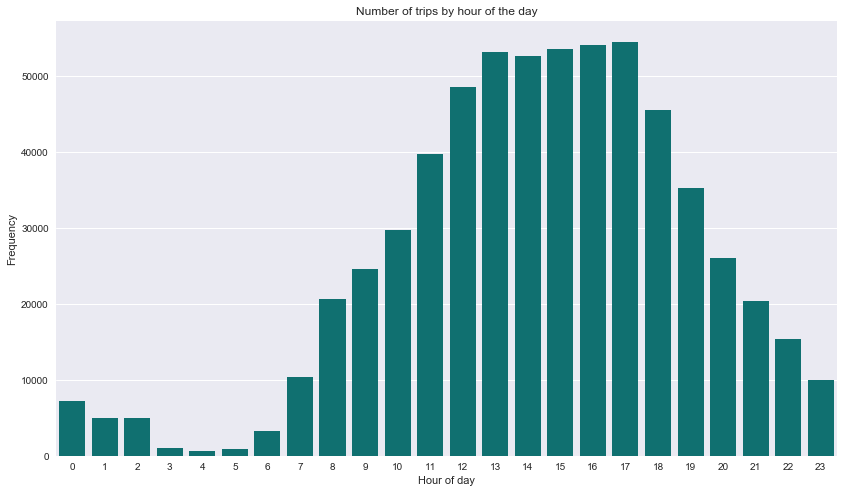

In [110]:
ax = sns.barplot(x='index', y='start_hour', data=hourly_counts_df, color='teal')

ax.figure.set_size_inches(14,8)
ax.set_title('Number of trips by hour of the day')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Frequency')

plt.show()

Voila!

Does this histogram make sense? What is it telling us? Does the behavior characterized in the plot demonstrate behavior your might expect?

Here we've plotted counts of number of trips by hour. We can visualize the **duration_minutes** column in a similar way, by binning the column into 5 minute bins.

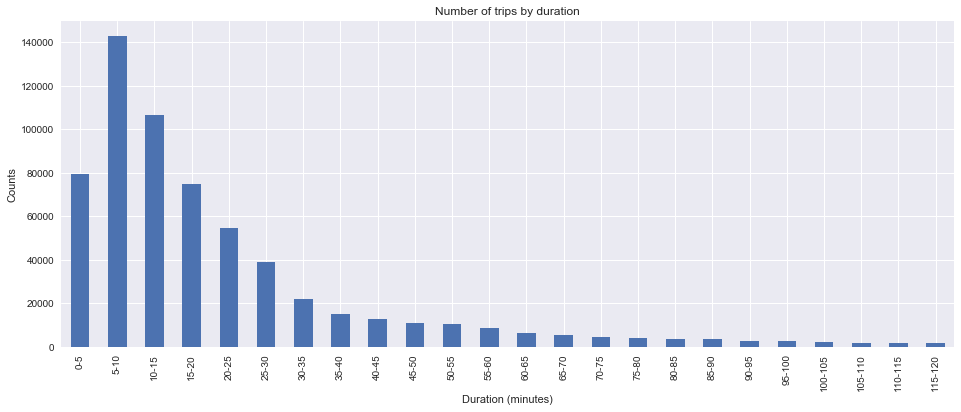

In [111]:
# Select the bin intervals
bins = np.arange(0,125,5)

# Return indices of half-open bins to which each value of column belongs.
duration_min_intervals = pd.cut(df['duration_minutes'], bins=bins, include_lowest=True)
five_minute_counts = duration_min_intervals.value_counts(sort=False)

# Create the plot
ax = five_minute_counts.plot.bar(rot=90, figsize=(16, 6))

# Formatting
ax.set_title('Number of trips by duration')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Counts')

# Format x tick labels
labels = ['{}-{}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
ax.set_xticklabels(labels)

plt.show()

An interesting question in this dataset is whether ridership patterns vary on different days of the week. We can begin to examine this by comparing the mean trip trip duration for each day of the week. This will also allow us to examine the mean trip duration for weekdays versus weekend trips.

In [112]:
# Pull out start day of the week into a seperate column where Monday=0, Sunday=6
df['start_day_of_week'] = df['start_time'].apply(lambda t: t.dayofweek)

In [113]:
# Group the rows by the start_day_of_week and compute summary statistics
df.groupby('start_day_of_week')['duration_minutes'].describe()

,count,mean,std,min,25%,50%,75%,max
start_day_of_week,,,,,,,,
0,74269.0,19.775236,20.098680,1.0,7.0,13.0,24.0,120.0
1,65626.0,17.606604,18.937446,1.0,6.0,11.0,21.0,120.0
2,67188.0,17.403703,18.351631,1.0,6.0,11.0,21.0,120.0
3,72337.0,18.139140,19.004834,1.0,7.0,11.0,22.0,120.0
4,97297.0,20.706024,20.095758,1.0,8.0,14.0,25.0,120.0
5,132552.0,25.336313,22.268594,1.0,11.0,18.0,30.0,120.0
6,107812.0,25.305263,22.508104,1.0,10.0,18.0,31.0,120.0


Notice that the mean and median trip durations for Saturday and Sunday are larger than those for the remaining days of the week. 

We can visualize these differences by day by incorporating some of the plots from Chapter 1 of OpenStats. As we are comparing numerical data (trip duration) across categories (days of the week), let's use violin plots, which are similar to box plots.

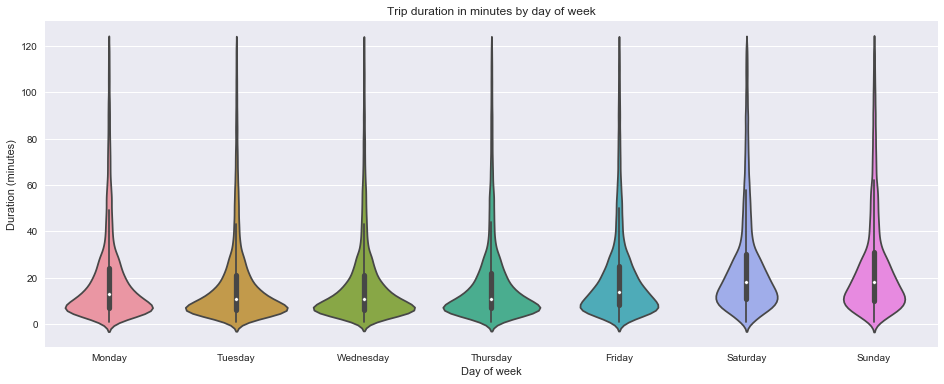

In [114]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

sns.violinplot(x="start_day_of_week", y="duration_minutes", data=df, ax=ax)

ax.set_title('Trip duration in minutes by day of week')
ax.set_xlabel('Day of week')
ax.set_ylabel('Duration (minutes)')
ax.set_xticklabels(days)

plt.show()

This violin plot demonstrates the difference in trip durations by day of the week.

First, we notice that the distribution of trip durations ocurring during weekday trips are similar in both the shape of the distribution (unimodal, similar centers, right skewed) and the median duration. This shape flattens out a bit on Fridays and is flattest on Saturday and Sunday, demonstrating higher variability. The median trip duration also increases on Friday and is highest on Saturday and Sunday, which continues to point towards different ridership patterns on weekdays versus weekends.

In fact, we might begin to characterize weekend bike rides as being more "joy ride-esque", as these trips tend to be longer than typical weekday rides.